In [1]:
import pandas as pd
from consts import *


df_embeds = pd.read_parquet(get_filename(TT.ALL, EMBED_PROVIDER.DISTILBERT, MEAN_METHOD.CENTROID))
df_train_all = pd.read_parquet('data/training-dataset.parquet')

In [2]:
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split

df_train = pd.merge(df_embeds, df_train_all[['username','category_enum','label']], how='left', on='username')
df_train = df_train.dropna(subset=['label'])
df_train = df_train.drop(columns=['username'])
df_train['category_enum'] = df_train['category_enum'].fillna('Missing')



labels = ['entertainment', 'food', 'travel', 'health and lifestyle', 'mom and children', 'fashion', 'tech', 'sports', 'art', 'gaming']

label_encoder = LabelEncoder()
label_encoder.fit(labels)

df_train['target'] = label_encoder.transform(df_train['label'])
df_train = df_train.drop(columns=['label'])


X = df_train.drop(columns=['target'])
y = df_train[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


encoder = TargetEncoder()
cat_encoded_train = encoder.fit_transform(X_train["category_enum"].to_numpy().reshape(-1,1), y_train['target'].tolist())
X_train['category_encoded'] = [row.tolist() for row in cat_encoded_train]
X_train = X_train[['embeds_wavg','category_encoded']]

X_train = pd.concat([pd.DataFrame(X_train['category_encoded'].tolist()), pd.DataFrame(X_train['embeds_wavg'].tolist())],axis=1)



cat_encoded_test = encoder.transform(X_test['category_enum'].to_numpy().reshape(-1,1))
X_test['category_encoded'] = [row.tolist() for row in cat_encoded_test]
X_test = pd.concat([pd.DataFrame(X_test['category_encoded'].tolist()), pd.DataFrame(X_test['embeds_wavg'].tolist())],axis=1)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()



In [3]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    random_state=42,
    verbose=True
)

#model = XGBClassifier(
#    objective='multi:softmax',
#    num_class=10,
#    learning_rate=0.01,  # Lower learning rate
#    max_depth=8,         # Try deeper trees
#    min_child_weight=3,  # Increase to prevent overfitting
#    n_estimators=200,    # More trees
#    subsample=0.8,       # Add some randomness
#    colsample_bytree=0.8,# Feature sampling
#    eval_metrix=['mlogloss','merror'],
#    early_stopping_rounds = 10,
#    random_state=42
#)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True

)

y_pred = model.predict(X_test)

0:	learn: 2.1753540	test: 2.1753540	test1: 2.1741030	best: 2.1741030 (0)	total: 595ms	remaining: 1m 58s
1:	learn: 2.0828488	test: 2.0828488	test1: 2.0932795	best: 2.0932795 (1)	total: 1.23s	remaining: 2m 1s
2:	learn: 2.0076538	test: 2.0076538	test1: 2.0261919	best: 2.0261919 (2)	total: 1.81s	remaining: 1m 59s
3:	learn: 1.9467110	test: 1.9467110	test1: 1.9688891	best: 1.9688891 (3)	total: 2.41s	remaining: 1m 57s
4:	learn: 1.9075489	test: 1.9075489	test1: 1.9323116	best: 1.9323116 (4)	total: 3.03s	remaining: 1m 58s
5:	learn: 1.8580385	test: 1.8580385	test1: 1.8908551	best: 1.8908551 (5)	total: 3.56s	remaining: 1m 55s
6:	learn: 1.8172877	test: 1.8172877	test1: 1.8596941	best: 1.8596941 (6)	total: 4.1s	remaining: 1m 53s
7:	learn: 1.7713660	test: 1.7713660	test1: 1.8188619	best: 1.8188619 (7)	total: 4.66s	remaining: 1m 51s
8:	learn: 1.7396658	test: 1.7396658	test1: 1.7947864	best: 1.7947864 (8)	total: 5.16s	remaining: 1m 49s
9:	learn: 1.7076013	test: 1.7076013	test1: 1.7663972	best: 1.76639


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.19      0.25        36
           1       0.49      0.49      0.49        70
           2       0.73      0.72      0.73        65
           3       0.83      0.90      0.86       101
           4       0.00      0.00      0.00         3
           5       0.61      0.75      0.67       102
           6       0.50      0.15      0.24        26
           7       0.84      0.75      0.79        28
           8       0.68      0.86      0.76        63
           9       0.73      0.61      0.67        54

    accuracy                           0.67       548
   macro avg       0.58      0.54      0.55       548
weighted avg       0.65      0.67      0.65       548


Additional Metrics:
Accuracy: 0.6715
Macro F1: 0.5454
Weighted F1: 0.6538
Macro Precision: 0.5761
Macro Recall: 0.5431


/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 

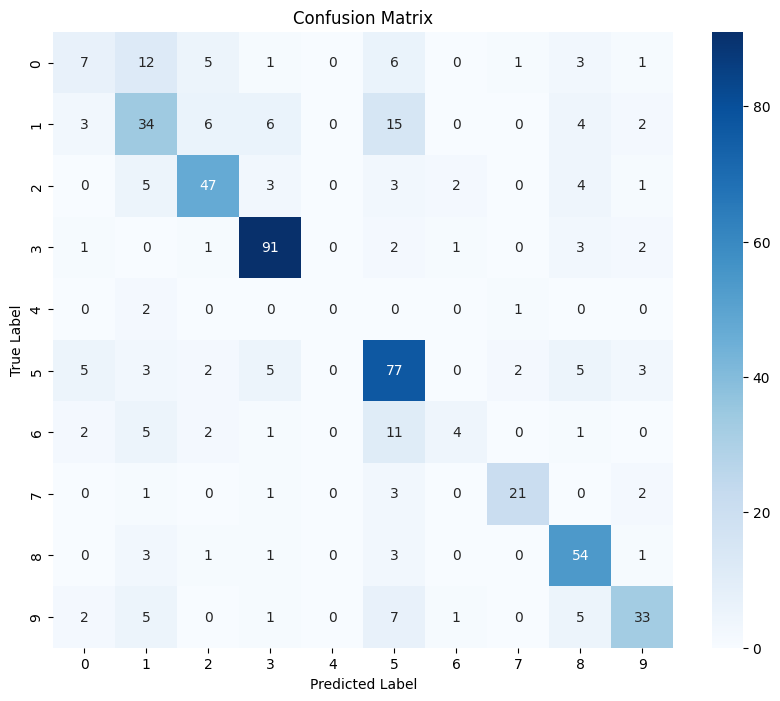

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Print detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

